<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/numba_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
from numba import jit, njit, vectorize

## What is Numba?
Numba is a **just-in-time**, **type-specializing**, **function compiler** for accelerating **numerically-focused** Python. That's a long list, so let's break down those terms:

+ **function compiler**: Numba compiles Python functions, not entire applications, and not parts of functions. Numba does not replace your Python interpreter, but is just another Python module that can turn a function into a (usually) faster function.
+ **type-specializing**: Numba speeds up your function by generating a specialized implementation for the specific data types you are using. Python functions are designed to operate on generic data types, which makes them very flexible, but also very slow. In practice, you only will call a function with a small number of argument types, so Numba will generate a fast implementation for each set of types.
+ **just-in-time**: Numba translates functions when they are first called. This ensures the compiler knows what argument types you will be using. This also allows Numba to be used interactively in a Jupyter notebook just as easily as a traditional application.
+ **numerically-focused**: Currently, Numba is focused on numerical data types, like int, float, and complex. There is very limited string processing support, and many string use cases are not going to work well on the GPU. To get best results with Numba, you will likely be using NumPy arrays.

### Problem 1 - A First Numba Function

**1a)** To start our exploration of Numba's features, let's write a python function to add two numbers. We'll creatively name it `add`:

In [0]:
def add(x, y):
  return x + y # add code here

Now, test the function, first with two scalar integers:

In [3]:
add(1, 2) # add code here

3

**1b)** With Numpy, we can use our function to add not just scalars, but vectors as well. Using your favorite array creation routine, create two integer arrays with ten elements each, called `a` and `b`, and use your `add` function to add them.

In [4]:
a = np.arange(0,10) # add code here
b = np.arange(1,11) # add code here

add(a, b) # add code here

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

Okay, so our function can add things. Now, let's use Numba's `jit` function to create a Numba version of our addition function:

In [0]:
numba_add = jit(add)

More commonly, you will use `jit` as a decorator, by adding `@jit` to the line above your function definition, but the above version shows you that at heart, `@jit` is just a python function that takes other functions as its argument!

**1c)**  By default, a Numba function saves the original python version of the function in the variable `py_func`. Check that the original python version gives you the same answer as the Numba version.

In [11]:
print(add(a,b)) #add code here
print(numba_add(a,b)) #add code here
print(numba_add.py_func(a,b)) #add code here

[ 1  3  5  7  9 11 13 15 17 19]
[ 1  3  5  7  9 11 13 15 17 19]
[ 1  3  5  7  9 11 13 15 17 19]


#### Profiling
A central feature of parallel programming, Numba, and writing efficient code more generally is **profiling**, or understanding how long various pieces of your program take to run. Profiling tools are becoming ever more sophisticated, but for today we're going to stick with the tried-and-true method of timing things. An easy way to do this in python is using the `%timeit` magic function. Let's try it out on our addition function:

In [10]:
%timeit add(1,2)

The slowest run took 9.13 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 163 ns per loop


What's going on here? `%timeit` is running our function many times, and then reporting the average time it takes to run. This is generally a better approach than timing a single function execution, because it accounts for random events that may cause any given run to perform poorly.

**1d)** Compare the time it takes to run your function with scalar vs array arguments, then your function vs python's add function (the standard ''+'' operator).

In [12]:
%timeit add(1,2) # add code here
%timeit add(a, b) # add code here
%timeit a + b # add code here

The slowest run took 15.70 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 163 ns per loop
The slowest run took 52.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 622 ns per loop
The slowest run took 49.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 498 ns per loop


So, scalars are faster than arrays (makes sense), and python's addition function is better than ours (seems reasonable). Now, let's see how fast our pre-compiled Numba addition function is.

In [13]:
%timeit numba_add(a,b) # add code here

The slowest run took 40.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 759 ns per loop


Hold on - our new pre-compiled function is running even slower than the original python version! What's going on here?

### Problem 2 - A Better Numba Function

(This problem borrowed from [seibert's 2018 gtc numba tutorial](https://github.com/ContinuumIO/gtc2018-numba).)

As we saw in the first example, Numba isn't going to speed up everything. Generally, Numba will help you most in circumstances where python's line-by-line interperability and lack of type casting is slowing it down. We can use a slightly more complicated function to demonstrate this. The following is a function to calculate the hypotenuse of two numbers, that has been carefully designed to compensate for the computer's finite precision representation of numbers (check out https://en.wikipedia.org/wiki/Hypot for more info).

**2a)** Use the `@jit` decorator to generate a Numba version of this function.

In [0]:
@jit # add code here
def hypotenuse(x, y):
  x = abs(x);
  y = abs(y);
  t = min(x, y);
  x = max(x, y);
  t = t / x;
  return x * math.sqrt(1+t*t)

**2b)** Use the `%timeit` function to determine whether the Numba version of the hyptonenuse function is better than the original Python implementation.

In [17]:
%timeit hypotenuse(3,4) # add code here
%timeit hypotenuse.py_func(3,4) # add code here

The slowest run took 25.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 257 ns per loop
The slowest run took 14.56 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 891 ns per loop


**2c)** Numba functions can call other functions, provided they are also Numba functions. Below is a function that loops through two numpy arrays and puts their sum into an output array. Modify the following function to calculate the hypotenuse instead.

In [0]:
@njit # this is an alias for @jit(nopython=True)
def ex_func(x, y, out):
  for i in range(x.shape[0]):
    out[i] = hypotenuse(x[i], y[i]) # change this line

In [21]:
in1 = np.arange(10, dtype=np.float64)
in2 = 2 * in1 + 1
out = np.empty_like(in1)

print('in1:', in1)
print('in2:', in2)

ex_func(in1, in2, out)

print('out:', out)

in1: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
in2: [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]
out: [ 1.          3.16227766  5.38516481  7.61577311  9.8488578  12.08304597
 14.31782106 16.55294536 18.78829423 21.02379604]


In [0]:
# This test will fail until you fix the ex1 function
np.testing.assert_almost_equal(out, np.hypot(in1, in2))

### Problem 3 - Fun with Fractals
Now that we've got the basics of the Numba `jit` decorator down, let's have a little fun. A classic example problem in parallel programming is the calculation of a fractal, because a large fraction of the work can be done in parallel. Below is some code that calculates whether a number is a member of the Julia set, and then computes the set on a discrete domain to calculate a fractal.

**3a)** Modify the code below to use Numba and test how much faster it is than the original python implementation.

In [0]:
@njit # add code here
def julia(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Julia
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(-0.8, 0.156)
    a = complex(x,y)
    for i in range(max_iters):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 1000:
            return 0
    return 255

In [0]:
@njit # add code here
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = julia(real, imag, iters)
            image[y, x] = color

    return image

In [29]:
image = np.zeros((500, 750), dtype=np.uint8)
%timeit create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)

1 loop, best of 3: 54.4 ms per loop


Want to see what you made? Run the following code to plot the image. Feel free to pick your favorite matplotlib color map :)

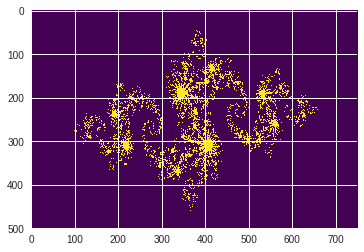

In [30]:
plt.imshow(image)
plt.viridis()
plt.show()

**3b)** There is more than one type of fractal in the world, however! Below is a function that determines membership in the Mandelbrot set. Modify the function using to take advantage of Numba, then modify the code above to produce a new pretty picture.

In [0]:
@njit #add code here
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i
    return 255

In [0]:
# add code here
@njit 
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

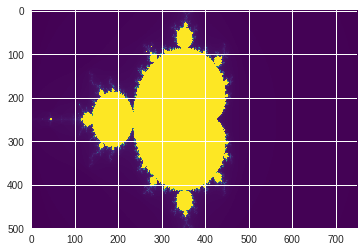

In [33]:
image = np.zeros((500, 750), dtype=np.uint8)
create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)
plt.imshow(image)
plt.viridis()
plt.show()

### Problem 4 - Typing

Much of the power of Numba comes from its ability to compile a specific version of a python function based on the **data types** of its arguments. The data type describes what kind of variables the function uses, and in Numpy and Numba, pre-defined type names are based on the kind and size of the number in memory. You can find the type of a variable (or array) using numpy's `dtype` object. For example, let's see what type our `a` array is.

In [34]:
a.dtype

dtype('int64')

This tells us the array contains integers, and each integer has been assigned 64bits in memory (or equivalently, 8 bytes). Most python functions are defined to work on arbitrary types, so that if you use the + operator, for example, you can add integers, floats, complex numbers, or even strings! However, this flexibility comes at a cost, performance-wise. Numba, on the other hand, compiles each function based on the types of its arguments, and infers the type of the result. You can see this if you run the `inspect_types` function on a numba function:

In [35]:
numba_add.inspect_types()

add (array(int64, 1d, C), array(int64, 1d, C))
--------------------------------------------------------------------------------
# File: <ipython-input-2-9397aad11c87>
# --- LINE 1 --- 
# label 0

def add(x, y):

  # --- LINE 2 --- 
  #   x = arg(0, name=x)  :: array(int64, 1d, C)
  #   y = arg(1, name=y)  :: array(int64, 1d, C)
  #   $0.3 = arrayexpr(expr=('+', [Var(x, <ipython-input-2-9397aad11c87> (2)), Var(y, <ipython-input-2-9397aad11c87> (2))]), ty=array(int64, 1d, C))  :: array(int64, 1d, C)
  #   del y
  #   del x
  #   $0.4 = cast(value=$0.3)  :: array(int64, 1d, C)
  #   del $0.3
  #   return $0.4

  return x + y # add code here




**4a)** Numba has inferred the types for this function based on how we've used it. Try out your `numba_add` function with two floating point numbers, then re-inspect the types of the Numba function. Are they the same?

In [36]:
#Add code here
numba_add(3.,4.)
numba_add.inspect_types()

add (array(int64, 1d, C), array(int64, 1d, C))
--------------------------------------------------------------------------------
# File: <ipython-input-2-9397aad11c87>
# --- LINE 1 --- 
# label 0

def add(x, y):

  # --- LINE 2 --- 
  #   x = arg(0, name=x)  :: array(int64, 1d, C)
  #   y = arg(1, name=y)  :: array(int64, 1d, C)
  #   $0.3 = arrayexpr(expr=('+', [Var(x, <ipython-input-2-9397aad11c87> (2)), Var(y, <ipython-input-2-9397aad11c87> (2))]), ty=array(int64, 1d, C))  :: array(int64, 1d, C)
  #   del y
  #   del x
  #   $0.4 = cast(value=$0.3)  :: array(int64, 1d, C)
  #   del $0.3
  #   return $0.4

  return x + y # add code here


add (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-2-9397aad11c87>
# --- LINE 1 --- 
# label 0

def add(x, y):

  # --- LINE 2 --- 
  #   x = arg(0, name=x)  :: float64
  #   y = arg(1, name=y)  :: float64
  #   $0.3 = x + y  :: float64
  #   del y
  #   del x
  #   $0.4 = ca

So far we have been using what Numba refers to as "lazy" (or "call-time") decoration. Basically, we've been letting Numba do the work of figuring out how we're using the function and inferring the types for us. Alternatively, if we know how we are going to use a given function, we can use "eager" (or "compile-time") decoration. To do this, we make use of the `vectorize` decorator. For example, if we want to make an integer-only version of our addition function, we could write:

In [0]:
@vectorize(['int64(int64, int64)'], target='cpu')
def add_ufunc(x, y):
  return x + y

#### Numpy Universal Functions
You'll notice a couple of new things here. In the first set of brackets, we have specified both the argument types of the function (those are inside the parentheses), as well as the return type of the function. This is just making explicit what Numba was previously inferring on our behalf. In second set of brackets you'll see that we have specified a 'target' architechture for the function. The default is `cpu`, which means that Numba is optimizing the function to your specific machine. Other options include `parallel`, which allows you to take advantage of multicore processors, and `cuda`, which we'll be discussing more tomorrow. You'll also notice that we called this a 'ufunc', which is short for [Universal Function](https://docs.scipy.org/doc/numpy/reference/ufuncs.html). In brief, universal functions are numpy functions that operate on ndarrays in element by element fashion. So if we pass two vectors to our `add_func`, they will be added together and a return vector of the same shape will be returned.

In [38]:
%timeit add_ufunc(a,b)

The slowest run took 153.01 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 512 ns per loop


**4b)** Try your ufunc out with a new target, 'parallel'. How does the speed compare? What if the array size is much larger?

In [39]:
big_array = np.arange(0,1000000) # add code here
%timeit add_ufunc(big_array, big_array) # add code here

The slowest run took 4.77 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.7 ms per loop


In [40]:
@vectorize(['int64(int64, int64)'], target='parallel')
def add_ufunc(x, y):
  return x + y
%timeit add_ufunc(big_array,big_array)

1000 loops, best of 3: 946 µs per loop


### Problem 5 - Direct Summation
(This problem borrowed in its entirety from [gforsyth's scipy17 numba tutorial](https://github.com/gforsyth/numba_tutorial_scipy2017).)

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.  

In [0]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * np.random.random()
        self.y = domain * np.random.random()
        self.z = domain * np.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [0]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

Next, we define a function to calculate the particle interaction via direct summation:

In [0]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

All that's left is to create a list of random particles with assigned masses:

In [0]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]

**5a)** Run the direct summation code and determine how long it takes with 10, 100, 1000 particles. Is there a relationship?

In [0]:
%timeit direct_sum(particles)

Because this is an $\mathcal{O} \left(n^2 \right)$ function, each addition of 10x particles costs 100x more in computational time. Given how expensive it is, let's see if we can improve things a bit with Numba. (This also happens to be a highly parallelizable problem, but we'll get to that tomorrow.)

**How do we use Numba on this problem?** There is a subtle issue here - Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development. But we'd like to have attributes for readable programming. The solution is to build NumPy custom dtypes.

In [0]:
particle_dtype = np.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double]})

In [0]:
myarray = np.ones(3, dtype=particle_dtype)

In [0]:
myarray

You can access an individual "attribute" like this:

In [0]:
myarray[0]['x'] = 2.0

**5b)** Write a `jit` function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within which to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.
​
For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

*Hint: You will probably want to loop over the number of particles within the function to assign attributes.*

In [0]:
@njit
def create_n_random_particles(n, m, domain=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = np.zeros((n), dtype=particle_dtype)
    #attribute access only in @jitted function
    for p in parts:
        p.x = np.random.random() * domain
        p.y = np.random.random() * domain
        p.z = np.random.random() * domain
        p.m = m
        p.phi = 0
    return parts

Now we'll create our array of particles using the new function.

In [0]:
particles = create_n_random_particles(1000, .001, 1)

In [0]:
particles[:3]

We don't have a `distance` method anymore, so we need to write a function to take care of that.

**5c)** Write a `jit` function `distance` to calculate the distance between two particles of dtype `particle_dtype`.

In [0]:
@njit
def distance(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1.x - part2.x)**2 + 
            (part1.y - part2.y)**2 + 
            (part1.z - part2.z)**2)**.5

In [0]:
distance(particles[0], particles[1])

In [0]:
%%timeit
distance(particles[0], particles[1])

**5d)** Modify the `direct_sum` function above to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential. Time the result and compare it to your previous version of this function.

In [0]:
@njit
def direct_sum(particles):
    for i, target in enumerate(particles):
        for j, source in enumerate(particles):
            if i != j:
                r = distance(target, source)
                target.phi += source.m / r
                
    return particles

In [0]:
%timeit direct_sum(particles)